In [35]:
import torchhd
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from functools import partial

from helpers import similarity_func_partial, normalised_bundle_partial


In [36]:
VSA_TYPES = ['FHRR', 'BSC', 'MAP', 'HRR']
VSA_TYPES = ['BSC', 'MAP', 'HRR']
DIMENSIONS = [2**i for i in range(8, 14)]
BUNDLE_SIZES = list(range(2, 300, 2))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cuda':
    torch.cuda.empty_cache()

batches = 20
item_memory_size = 10_000
MAX_BUNDLE_SIZE = BUNDLE_SIZES[-1]

# Evaluating normalized capacity of HD vectors
Capacity: How many elements can be stored/bundled in a vector while still being able to reliably retrieve theses elements?

In [37]:
prob_correct_tensor = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES), len(VSA_TYPES), batches)

for vsa_type_idx in tqdm(range(len(VSA_TYPES)), disable=True):
  vsa_type = VSA_TYPES[vsa_type_idx]
  print(f'vsa type: {vsa_type}')
  similarity_func = partial(similarity_func_partial, vsa_type)
  bundle_func = partial(normalised_bundle_partial, vsa_type)

  for batch in tqdm(range(batches), disable=False):
        # perc_corr_array = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES))
        # print(f'iteration: {batch + 1}')

        for d_idx in tqdm(range(len(DIMENSIONS)), disable=True):
            dim = DIMENSIONS[d_idx]
            item_memory = torchhd.random(item_memory_size, dim, vsa=vsa_type, device=device)

            # Sample MAX_BUNDLE_SIZE vectors from item memory for experiment
            random_indices = torch.randperm(item_memory_size)[:MAX_BUNDLE_SIZE]
            experiment_to_bundle_vectors = item_memory[random_indices]
            bundle_vector = torchhd.random(1, dim, vsa=vsa_type, device=device) #TODO: empty?

            for k_idx in range(len(BUNDLE_SIZES)):
                prev_k = BUNDLE_SIZES[k_idx - 1] if k_idx > 0 else 0
                k = BUNDLE_SIZES[k_idx]

                # add vectors to bundle
                for i in range(prev_k, k): # TODO: show results without clipping for MAP -> same as multiset
                    bundle_vector = bundle_func(bundle_vector, experiment_to_bundle_vectors[i])

                # find the k nearest vectors to bundle
                similarities = similarity_func(bundle_vector, item_memory)
                k_nearest_vectors_idx = torch.topk(similarities, k, largest=True).indices

                # check how many of the k nearest vectors are correct
                num_correct = np.intersect1d(k_nearest_vectors_idx.cpu().numpy(), random_indices.cpu().numpy()).shape[0]

                # perc_corr_array[d_idx, k_idx] = num_correct / k
                prob_correct_tensor[d_idx, k_idx, vsa_type_idx, batch] = num_correct / k
        
        # print(perc_corr_array)
        # prob_correct_tensor[:, :, vsa_type_idx, batch] = perc_corr_array
   
# compute mean and std over batches
prob_correct_mean = torch.mean(prob_correct_tensor, dim=3)
prob_correct_std = torch.std(prob_correct_tensor, dim=3)

vsa type: BSC


100%|██████████| 20/20 [00:40<00:00,  2.03s/it]


vsa type: MAP


100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


vsa type: HRR


100%|██████████| 20/20 [00:36<00:00,  1.82s/it]


### Line plots for each vsa type

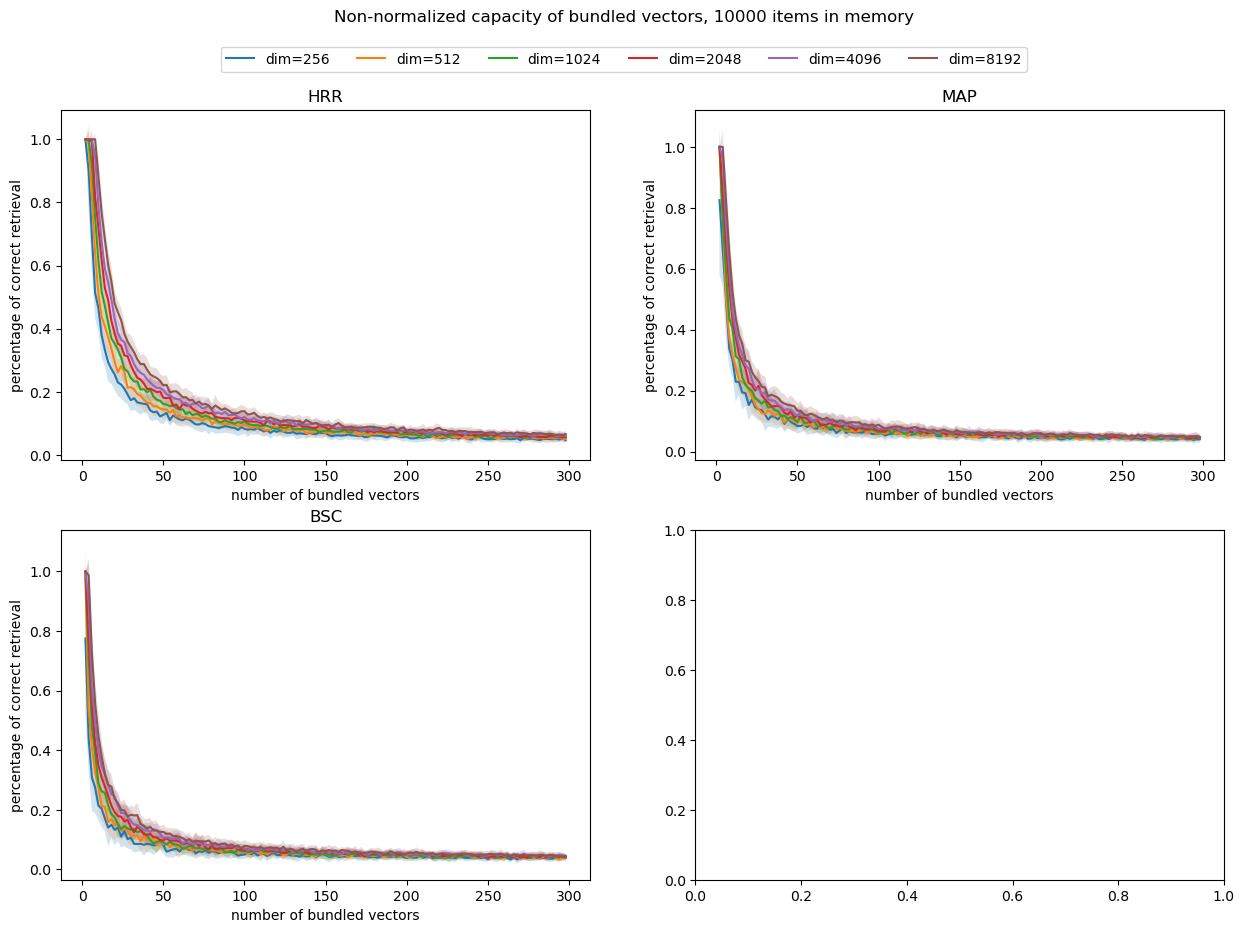

In [38]:
MAX_BUNDLE_SIZE_IDX = len(BUNDLE_SIZES)

fig, ax = plt.subplots(nrows=(len(VSA_TYPES)+1)//2, ncols=2, figsize=(15, 5 * ((len(VSA_TYPES)+1)//2)))
fig.suptitle(f'Non-normalized capacity of bundled vectors, {item_memory_size} items in memory')
# MAX_BUNDLE_SIZE_IDX = len(BUNDLE_SIZES)

for vsa_type_idx in range(len(VSA_TYPES)):
    vsa_type = VSA_TYPES[vsa_type_idx]
    row = (vsa_type_idx+1) // 2 - 1
    col = vsa_type_idx % 2
    for dim_idx in range(len(DIMENSIONS)):
        ax[row, col].plot(BUNDLE_SIZES[:MAX_BUNDLE_SIZE_IDX], prob_correct_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], label=f'dim={DIMENSIONS[dim_idx]}')
        ax[row, col].fill_between(BUNDLE_SIZES[:MAX_BUNDLE_SIZE_IDX], prob_correct_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx] - prob_correct_std[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], prob_correct_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx] + prob_correct_std[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], alpha=0.2)
    ax[row, col].set_title(vsa_type)
    ax[row, col].set_xlabel('number of bundled vectors')
    ax[row, col].set_ylabel('percentage of correct retrieval')

fig.legend(handles=ax[0, 0].get_lines(), labels=[f'dim={dim}' for dim in DIMENSIONS], ncol=len(DIMENSIONS), loc='upper center', bbox_to_anchor=(0.5, .95)) 

### Heatmaps for each vsa type

In [39]:
# fig, ax = plt.subplots(nrows=(len(VSA_TYPES)+1)//2, ncols=2, figsize=(15, 4 * ((len(VSA_TYPES)+1)//2)), gridspec_kw=dict(top=0.9, bottom=-0.2))
# fig.suptitle(f'Non-normalized capacity of bundled vectors, {item_memory_size} items in memory')
# for vsa_type_idx in range(len(VSA_TYPES)):
#     vsa_type = VSA_TYPES[vsa_type_idx]
#     row = (vsa_type_idx +1) // 2 - 1
#     col = vsa_type_idx % 2
#     ax[row, col].set_title(vsa_type)
#     ax[row, col] = sns.heatmap(prob_correct_mean.numpy()[::-1, ::len(BUNDLE_SIZES)//20, vsa_type_idx], ax=ax[row, col], xticklabels=BUNDLE_SIZES[::len(BUNDLE_SIZES)//20], yticklabels=DIMENSIONS[::-1], cbar_kws={'label': 'percentage of correct retrieval'})
#     ax[row, col].set_xlabel('number of bundled vectors')
#     ax[row, col].set_ylabel('dimensionality')


## First vector similarity study using sequentially bundled HD vectors

In [40]:
# MORE BATCHES?
# similarity to first vector
sim_first_vector_tensor = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES), len(VSA_TYPES), batches)
# probability of retrieval of first vector
retrieval_first_vector_tensor = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES), len(VSA_TYPES), batches)

for vsa_type_idx in tqdm(range(len(VSA_TYPES)), disable=True):
  vsa_type = VSA_TYPES[vsa_type_idx]
  print(f'vsa type: {vsa_type}')
  similarity_func = partial(similarity_func_partial, vsa_type)
  bundle_func = partial(normalised_bundle_partial, vsa_type)
  for batch in tqdm(range(batches), disable=False):
      # sim_first_vector_array = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES))
      # retrieval_first_vector_array = torch.zeros(len(DIMENSIONS), len(BUNDLE_SIZES))
      # print(f'iteration: {batch + 1}')

      for d_idx in tqdm(range(len(DIMENSIONS)), disable=True):
          dim = DIMENSIONS[d_idx]
          item_memory = torchhd.random(item_memory_size, dim, vsa=vsa_type, device=device)

          # sample MAX_BUNDLE_SIZE vectors from item memory
          random_indices = torch.randperm(item_memory_size)[:MAX_BUNDLE_SIZE]
          experiment_to_bundle_vectors = item_memory[random_indices]
          first_vector = experiment_to_bundle_vectors[0]
          # TODO: check why empty get -1, 1 elements when bundled for HRR
          bundle_vector = torchhd.random(1, dim, vsa=vsa_type, device=device) # important sidenote: When bundled with a random-hypervector x, the result is ~x. 
                                                                             # Because of the low precession of the BSC model an empty set cannot be explicitly represented, therefore the returned hypervectors are identical to random-hypervectors.

          for k_idx in range(len(BUNDLE_SIZES)):
              prev_k = BUNDLE_SIZES[k_idx - 1] if k_idx > 0 else 0
              k = BUNDLE_SIZES[k_idx]

              # add vectors to bundle
              for i in range(prev_k, k):
                  bundle_vector = bundle_func(bundle_vector, experiment_to_bundle_vectors[i])
              # add similarity of first vector to bundle to array
              # sim_first_vector_array[d_idx, k_idx] = similarity_func(first_vector, bundle_vector)
              sim_first_vector_tensor[d_idx, k_idx, vsa_type_idx, batch] = similarity_func(first_vector, bundle_vector)

              # find the k nearest vectors to bundle
              similarities = similarity_func(bundle_vector, item_memory)
              k_nearest_vectors_idx = torch.topk(similarities, k, largest=True).indices

              # check if the first vector is in the k nearest vectors
              # retrieval_first_vector_array[d_idx, k_idx] = 1 if random_indices[0] in k_nearest_vectors_idx else 0
              retrieval_first_vector_tensor[d_idx, k_idx, vsa_type_idx, batch] = 1 if random_indices[0] in k_nearest_vectors_idx else 0

      # sim_first_vector_tensor[:, :, vsa_type_idx, batch] = sim_first_vector_array
      # retrieval_first_vector_tensor[:, :, vsa_type_idx, batch] = retrieval_first_vector_array

# compute mean and std over batches
sim_first_vector_mean = torch.mean(sim_first_vector_tensor, dim=3)
sim_first_vector_std = torch.std(sim_first_vector_tensor, dim=3)

retrieval_first_vector_mean = torch.mean(retrieval_first_vector_tensor, dim=3)
retrieval_first_vector_std = torch.std(retrieval_first_vector_tensor, dim=3) # is this relevant?

vsa type: BSC


100%|██████████| 20/20 [00:44<00:00,  2.22s/it]


vsa type: MAP


100%|██████████| 20/20 [00:43<00:00,  2.17s/it]


vsa type: HRR


100%|██████████| 20/20 [00:47<00:00,  2.36s/it]


### Line plots for each vsa type

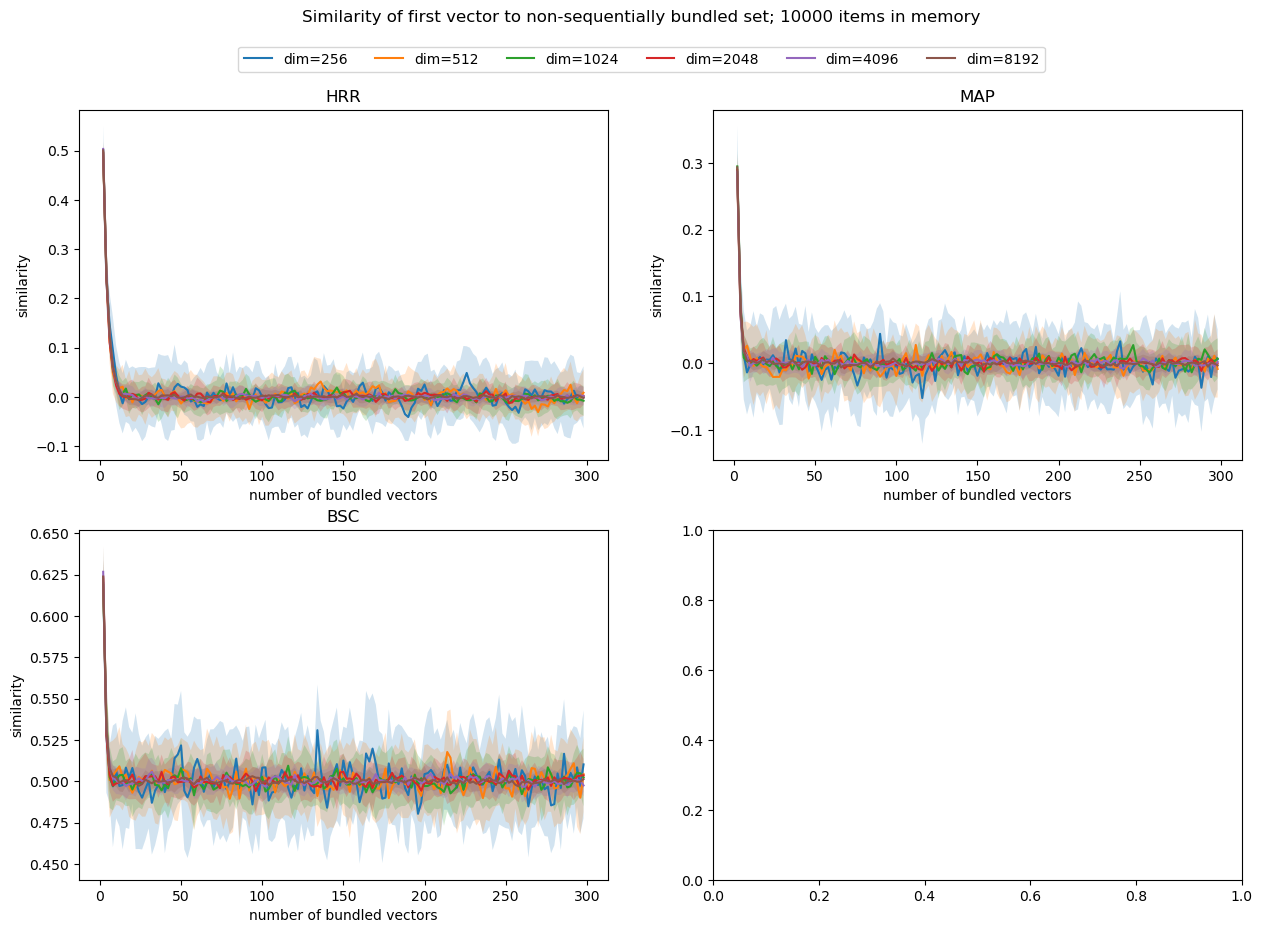

In [41]:
# MAX_BUNDLE_SIZE_IDX = 10

fig, ax = plt.subplots(nrows=(len(VSA_TYPES)+1)//2, ncols=2, figsize=(15, 5 * ((len(VSA_TYPES)+1)//2)))
fig.suptitle(f'Similarity of first vector to non-sequentially bundled set; {item_memory_size} items in memory')
for vsa_type_idx in range(len(VSA_TYPES)):
    vsa_type = VSA_TYPES[vsa_type_idx]
    row = (vsa_type_idx +1) // 2 - 1
    col = vsa_type_idx % 2
    ax[row, col].set_title(vsa_type)
    for dim_idx in range(len(DIMENSIONS)):
        ax[row, col].plot(BUNDLE_SIZES[:MAX_BUNDLE_SIZE_IDX], sim_first_vector_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], label=f'dim={DIMENSIONS[dim_idx]}')
        ax[row, col].fill_between(BUNDLE_SIZES[:MAX_BUNDLE_SIZE_IDX], sim_first_vector_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx] - sim_first_vector_std[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], sim_first_vector_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx] + sim_first_vector_std[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], alpha=0.2)
        # ax[row, col].plot(BUNDLE_SIZES[:MAX_BUNDLE_SIZE_IDX], sim_random_vector_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], label=f'dim={DIMENSIONS[dim_idx]}')
        # ax[row, col].fill_between(BUNDLE_SIZES[:MAX_BUNDLE_SIZE_IDX], sim_random_vector_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx] - sim_random_vector_std[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], sim_random_vector_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx] + sim_random_vector_std[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], alpha=0.1)
    ax[row, col].set_xlabel('number of bundled vectors')
    ax[row, col].set_ylabel('similarity')
fig.legend(handles=ax[0, 0].get_lines(), labels=[f'dim={dim}' for dim in DIMENSIONS], ncol=len(DIMENSIONS), loc='upper center', bbox_to_anchor=(0.5, .95)) 
    

### Heatmaps for each vsa type

In [42]:
# fig, ax = plt.subplots(nrows=(len(VSA_TYPES)+1)//2, ncols=2, figsize=(15, 4 * ((len(VSA_TYPES)+1)//2)), gridspec_kw=dict(top=0.9, bottom=-0.2))
# fig.suptitle(f'Similarity of first vector to sequentially bundled set; {item_memory_size} items in memory')

# for vsa_type_idx in range(len(VSA_TYPES)):
#     vsa_type = VSA_TYPES[vsa_type_idx]
#     row = (vsa_type_idx +1) // 2 - 1
#     col = vsa_type_idx % 2
#     ax[row, col].set_title(vsa_type)
#     ax[row, col] = sns.heatmap(sim_first_vector_mean.numpy()[::-1, ::len(BUNDLE_SIZES)//20, vsa_type_idx], ax=ax[row, col], xticklabels=BUNDLE_SIZES[::len(BUNDLE_SIZES)//20], yticklabels=DIMENSIONS[::-1], cbar_kws={'label': 'similarity'})
#     ax[row, col].set_xlabel('number of bundled vectors')
#     ax[row, col].set_ylabel('dimensionality')
  

### Line plots for each vsa type

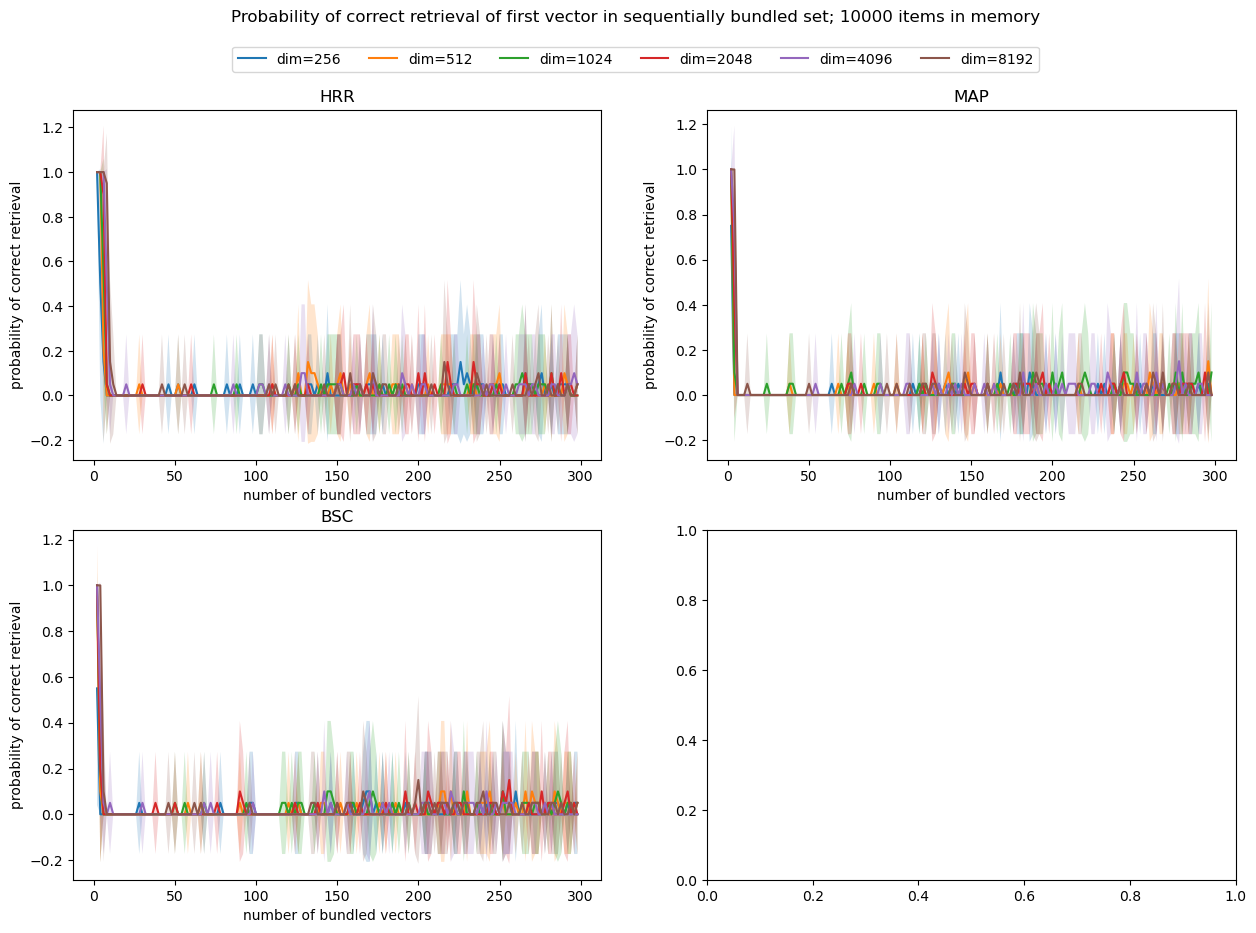

In [43]:
fig, ax = plt.subplots(nrows=(len(VSA_TYPES)+1)//2, ncols=2, figsize=(15, 5 * ((len(VSA_TYPES)+1)//2)))
fig.suptitle(f'Probability of correct retrieval of first vector in sequentially bundled set; {item_memory_size} items in memory')

for vsa_type_idx in range(len(VSA_TYPES)):
    vsa_type = VSA_TYPES[vsa_type_idx]
    row = (vsa_type_idx +1) // 2 - 1
    col = vsa_type_idx % 2
    ax[row, col].set_title(vsa_type)
    for dim_idx in range(len(DIMENSIONS)):
        ax[row, col].plot(BUNDLE_SIZES[:MAX_BUNDLE_SIZE_IDX], retrieval_first_vector_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], label=f'dim={DIMENSIONS[dim_idx]}')
        ax[row, col].fill_between(BUNDLE_SIZES[:MAX_BUNDLE_SIZE_IDX], retrieval_first_vector_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx] - retrieval_first_vector_std[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], retrieval_first_vector_mean[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx] + retrieval_first_vector_std[dim_idx, :MAX_BUNDLE_SIZE_IDX, vsa_type_idx], alpha=0.2)
    ax[row, col].set_xlabel('number of bundled vectors')
    ax[row, col].set_ylabel('probability of correct retrieval')
fig.legend(handles=ax[0, 0].get_lines(), labels=[f'dim={dim}' for dim in DIMENSIONS], ncol=len(DIMENSIONS), loc='upper center', bbox_to_anchor=(0.5, .95)) 

### Results

Extremely low probability of retrieving first bundled element.

### Heatmaps for each vsa type

In [44]:
# fig, ax = plt.subplots(nrows=(len(VSA_TYPES)+1)//2, ncols=2, figsize=(15, 5 * ((len(VSA_TYPES)+1)//2)))
# fig.suptitle(f'Probability of correct retrieval of first vector in sequentially bundled set; {item_memory_size} items in memory')

# for vsa_type_idx in range(len(VSA_TYPES)):
#     vsa_type = VSA_TYPES[vsa_type_idx]
#     row = (vsa_type_idx +1) // 2 - 1
#     col = vsa_type_idx % 2
#     ax[row, col].set_title(vsa_type)
#     ax[row, col] = sns.heatmap(retrieval_first_vector_mean.numpy()[::-1, ::len(BUNDLE_SIZES)//10, vsa_type_idx], ax=ax[row, col], xticklabels=BUNDLE_SIZES[::len(BUNDLE_SIZES)//10], yticklabels=DIMENSIONS[::-1], cbar_kws={'label': 'percentage of correct retrieval'})
#     ax[row, col].set_xlabel('number of bundled vectors')
#     ax[row, col].set_ylabel('dimensionality')